{'Shape': (1340, 13), 'Columns': ['CASENUM', 'ATTORNEY', 'CLMSEX', 'CLMINSUR', 'SEATBELT', 'CLMAGE', 'LOSS', 'Accident_Severity', 'Claim_Amount_Requested', 'Claim_Approval_Status', 'Settlement_Amount', 'Policy_Type', 'Driving_Record'], 'Missing Values': CASENUM                     0
ATTORNEY                    0
CLMSEX                     12
CLMINSUR                   41
SEATBELT                   48
CLMAGE                    189
LOSS                        0
Accident_Severity           0
Claim_Amount_Requested      0
Claim_Approval_Status       0
Settlement_Amount           0
Policy_Type                 0
Driving_Record              0
dtype: int64, 'Sample Rows':    CASENUM  ATTORNEY  CLMSEX  CLMINSUR  SEATBELT  CLMAGE      LOSS  \
0        5         0     0.0       1.0       0.0    50.0   2367.86   
1        3         1     1.0       0.0       0.0    18.0   3746.41   
2       66         1     0.0       1.0       0.0     5.0  14282.43   
3       70         0     0.0       1.0       1.

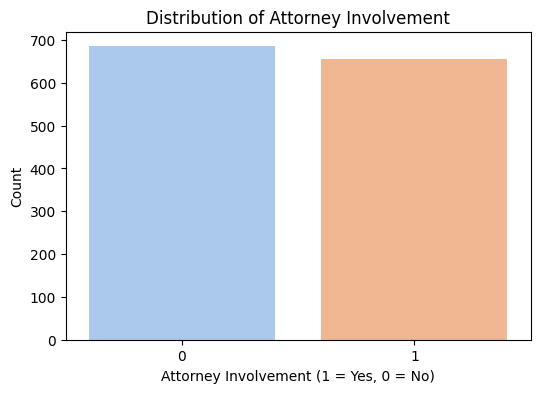

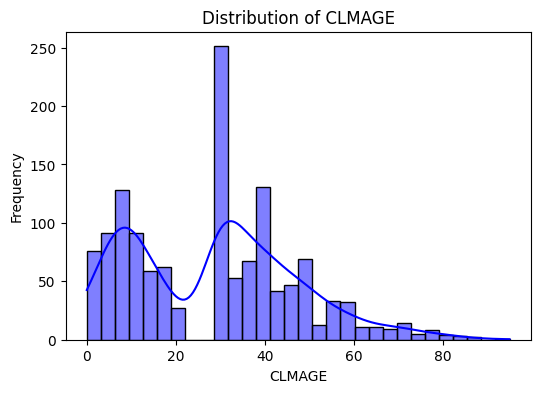

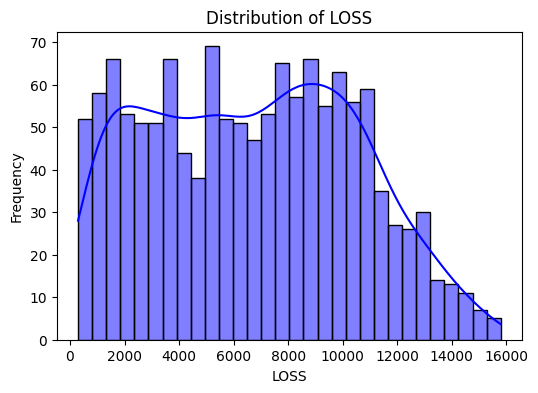

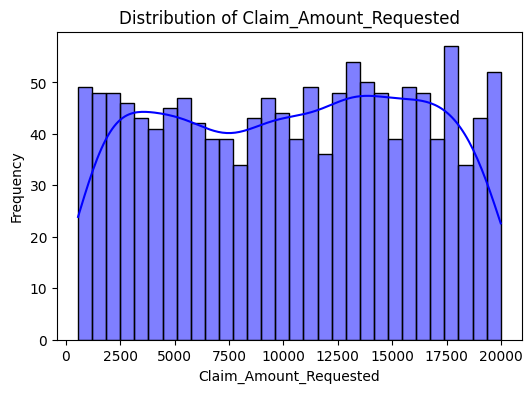

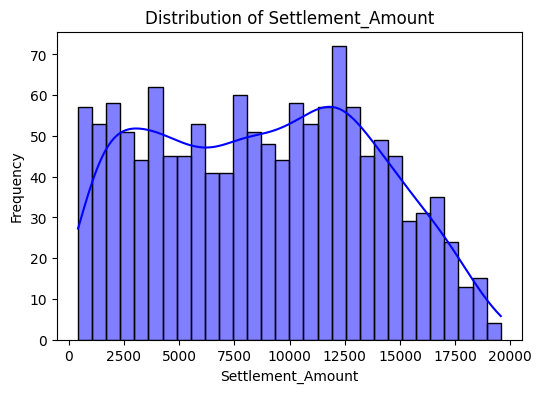

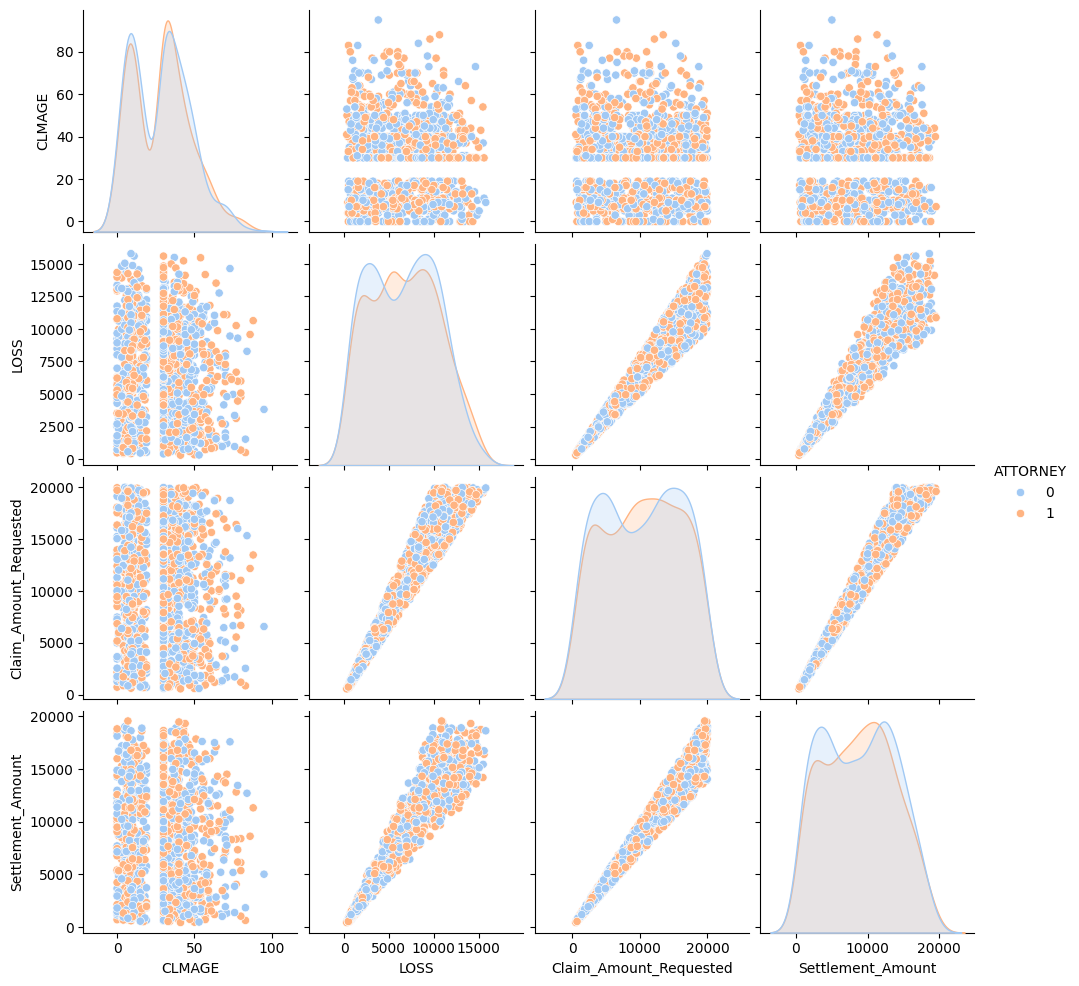

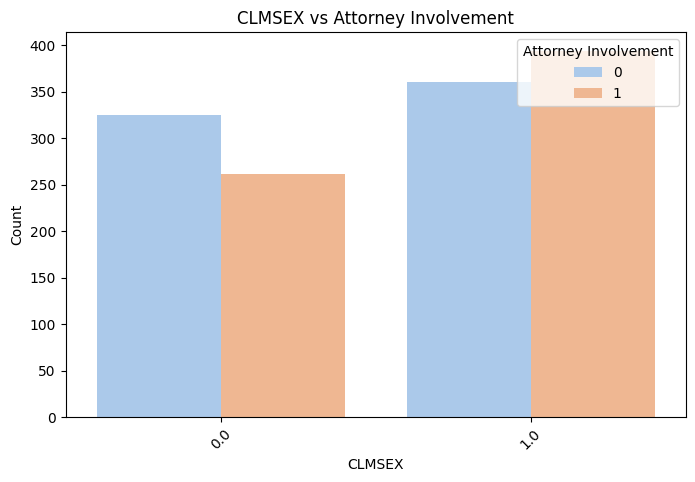

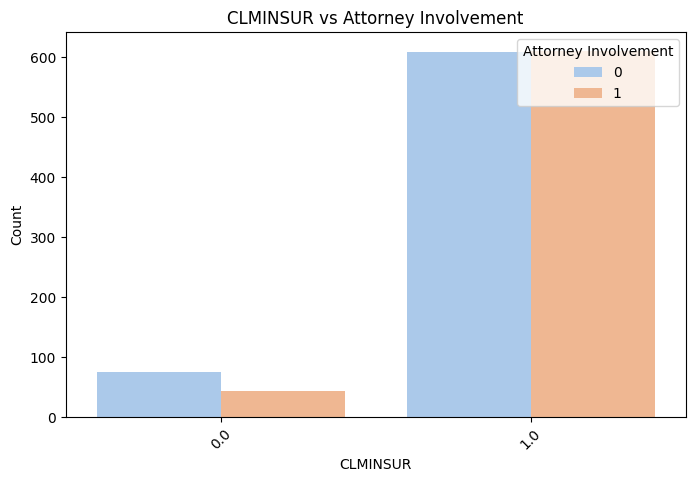

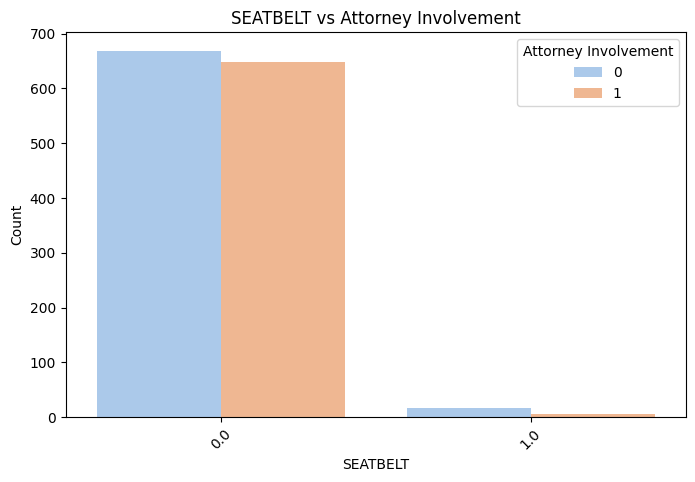

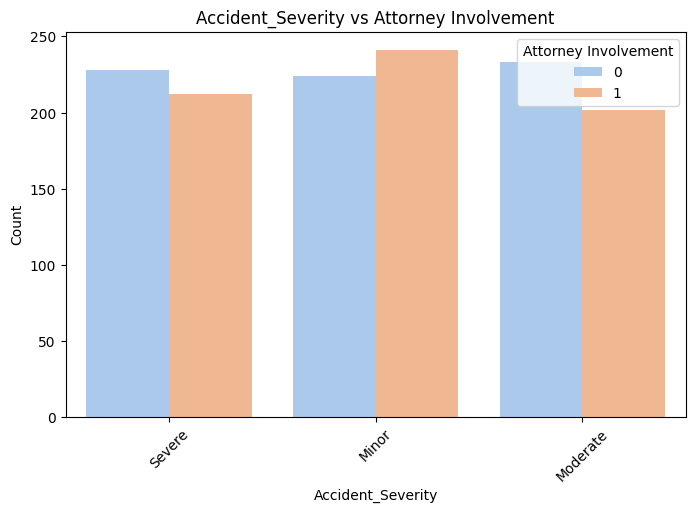

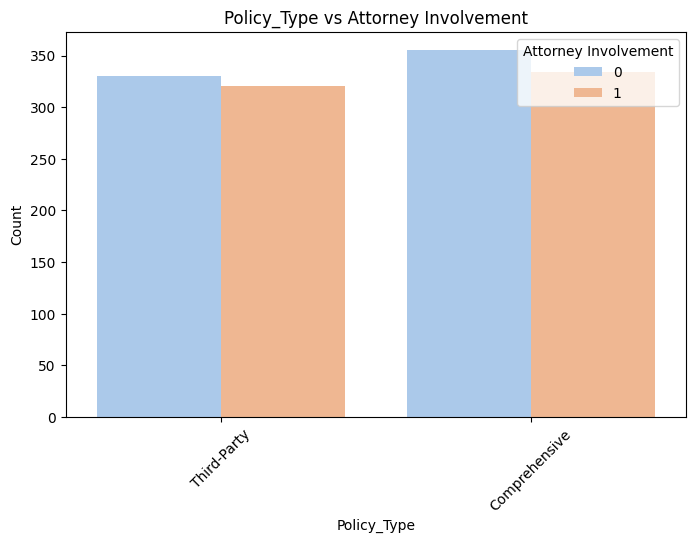

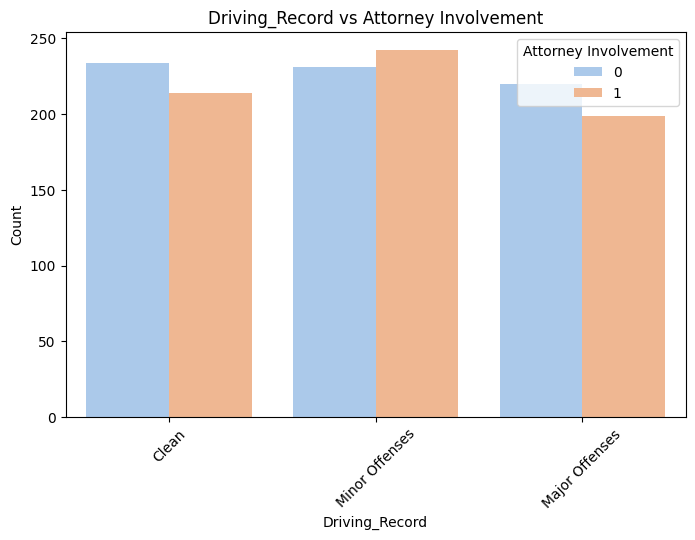

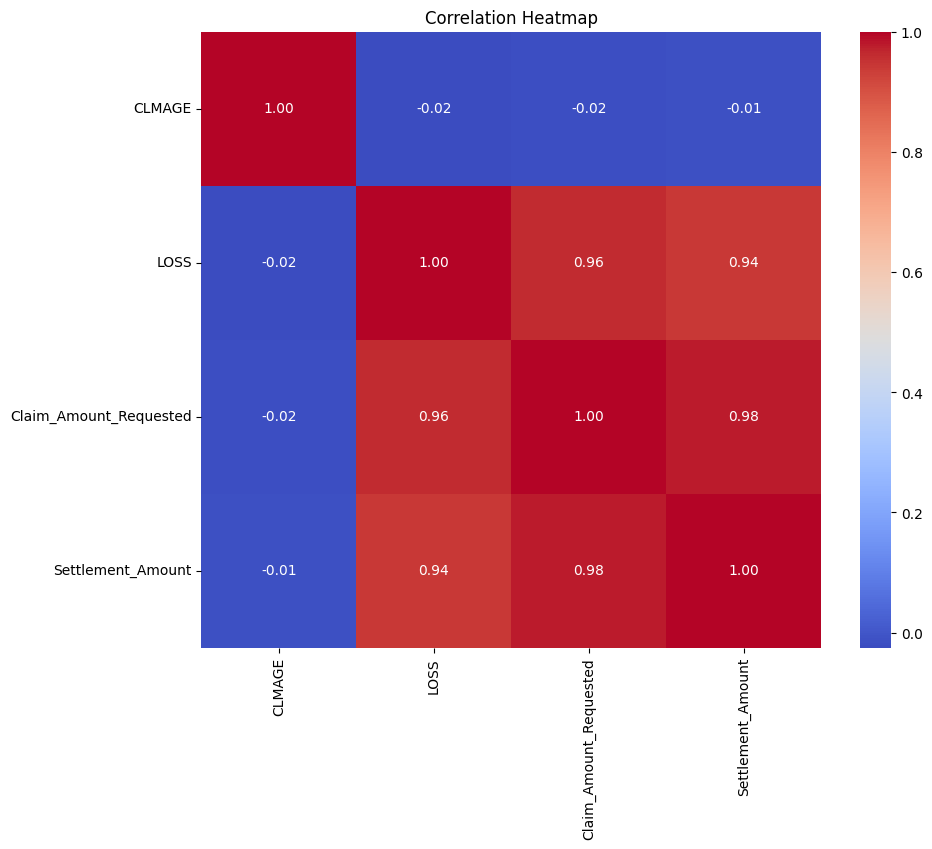

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE  # For class balancing
from sklearn.feature_selection import SelectFromModel  # For feature selection
import joblib

# Load the dataset
file_path = 'Insurance\\Updated_Claimants_Dataset.csv'
data = pd.read_csv(file_path)

# Step 1: Basic Information About the Dataset
# Understanding the dataset is crucial for preprocessing and modeling.
data_info = {
    "Shape": data.shape,  # Number of rows and columns
    "Columns": data.columns.tolist(),  # List of column names
    "Missing Values": data.isnull().sum(),  # Count of missing values in each column
    "Sample Rows": data.head()  # First few rows of the dataset
}
print(data_info)

# Step 2: Handle Duplicate Values
# Duplicate rows can skew the analysis and model performance.
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    data = data.drop_duplicates()  # Remove duplicate rows
    print("Duplicate rows removed.")

# Step 3: Handle Missing Values
# Missing values can lead to errors during modeling. We handle them by imputation.
data["CLMSEX"] = data["CLMSEX"].fillna(data["CLMSEX"].mode()[0])  # Fill with mode (most frequent value)
data["CLMINSUR"] = data["CLMINSUR"].fillna(data["CLMINSUR"].mode()[0])
data["SEATBELT"] = data["SEATBELT"].fillna(data["SEATBELT"].mode()[0])
data["CLMAGE"] = data["CLMAGE"].fillna(data["CLMAGE"].median())  # Fill with median for numerical columns

# Verify that there are no missing values left
missing_values_after_imputation = data.isnull().sum()
print(missing_values_after_imputation)

# Step 4: Exploratory Data Analysis (EDA)
# EDA helps us understand the distribution of data and relationships between features.

# Distribution of Target Variable (ATTORNEY)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="ATTORNEY", hue="ATTORNEY", palette="pastel", legend=False)
plt.title("Distribution of Attorney Involvement")
plt.xlabel("Attorney Involvement (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Distribution of Numerical Features
numerical_features = ["CLMAGE", "LOSS", "Claim_Amount_Requested", "Settlement_Amount"]
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[feature], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

# Pairplot for Numerical Features
sns.pairplot(data, vars=numerical_features, hue="ATTORNEY", palette="pastel")
plt.show()

# Categorical Features vs Target Variable
categorical_features = ["CLMSEX", "CLMINSUR", "SEATBELT", "Accident_Severity", "Policy_Type", "Driving_Record"]
for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=feature, hue="ATTORNEY", palette="pastel")
    plt.title(f"{feature} vs Attorney Involvement")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="Attorney Involvement", loc="upper right")
    plt.xticks(rotation=45)
    plt.show()

# Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
corr_matrix = data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



In [2]:
# Step 5: Feature Engineering and Preprocessing
# Separate features and target variable
X = data.drop(columns=["CASENUM", "ATTORNEY"])  # Drop irrelevant columns
y = data["ATTORNEY"]

# Define categorical and numerical columns
categorical_columns = ["Accident_Severity", "Policy_Type", "Driving_Record"]
binary_columns = ["CLMSEX", "CLMINSUR", "SEATBELT"]
numerical_columns = ["CLMAGE", "LOSS", "Claim_Amount_Requested", "Settlement_Amount"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),  # Scale numerical features
        ("cat", OneHotEncoder(drop="first"), categorical_columns),  # One-hot encode categorical features
        ("binary", "passthrough", binary_columns)  # Keep binary columns as-is
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [3]:
# Step 6: Class Balancing using SMOTE
# SMOTE is used to balance imbalanced datasets by generating synthetic samples.
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [4]:
# Step 7: Feature Selection using Lasso
# Lasso regression can be used for feature selection by shrinking less important features to zero.
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train_balanced, y_train_balanced)

# Select important features
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_balanced)
X_test_selected = selector.transform(X_test)

In [5]:
# Step 8: Model Building
# We will train and evaluate multiple models: Random Forest, Logistic Regression, SVM, and KNN.

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train_balanced)


RandomForestClassifier(random_state=42)

In [6]:
# Train a Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected, y_train_balanced)

LogisticRegression(random_state=42)

In [7]:
# Train a Support Vector Classifier
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train_selected, y_train_balanced)

SVC(probability=True, random_state=42)

In [8]:
# Train a K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_selected, y_train_balanced)

KNeighborsClassifier()

In [9]:
# Evaluate Models
models = {
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "SVC": svc_model,
    "KNN": knn_model
}

for model_name, model in models.items():
    print(f"--- {model_name} ---")
    y_pred = model.predict(X_test_selected)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1]))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


--- Random Forest ---
Accuracy: 0.5335820895522388
ROC AUC Score: 0.529296875
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.43      0.47       128
           1       0.55      0.63      0.58       140

    accuracy                           0.53       268
   macro avg       0.53      0.53      0.53       268
weighted avg       0.53      0.53      0.53       268

Confusion Matrix:
 [[55 73]
 [52 88]]
--- Logistic Regression ---
Accuracy: 0.5186567164179104
ROC AUC Score: 0.5184430803571428
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50       128
           1       0.54      0.53      0.53       140

    accuracy                           0.52       268
   macro avg       0.52      0.52      0.52       268
weighted avg       0.52      0.52      0.52       268

Confusion Matrix:
 [[65 63]
 [66 74]]
--- SVC ---
Accuracy: 0.48880597014925375
ROC AUC Sco

In [10]:
# Step 9: Model Selection
# Compare models and select the best-performing one.
best_model_name = max(models, key=lambda x: accuracy_score(y_test, models[x].predict(X_test_selected)))
best_model = models[best_model_name]
print(f"The best model is: {best_model_name}")



The best model is: Random Forest


In [11]:
# Step 10: Hyperparameter Tuning for the Best Model
# Use GridSearchCV to optimize hyperparameters for the best model.
if best_model_name == "Random Forest":
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }
    grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring="accuracy")
    grid_search.fit(X_train_selected, y_train_balanced)
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [12]:

# Step 11: Save the Preprocessor, Selector, and Best Model
# Save the components for future use in inference.
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [13]:
joblib.dump(selector, "feature_selector.pkl")


['feature_selector.pkl']

In [14]:
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']

In [15]:
# Step 12: Model Deployment using Streamlit
# Create a Streamlit app for deployment.
with open("streamlit_app.py", "w") as f:
    f.write("""
import streamlit as st
import joblib
import numpy as np
import pandas as pd

# Load preprocessor, feature selector, and model
preprocessor = joblib.load("preprocessor.pkl")
selector = joblib.load("feature_selector.pkl")
model = joblib.load("best_model.pkl")

st.title("Attorney Involvement Prediction")
st.write("Predict whether an attorney will be involved in a claim.")

# Input fields
clmage = st.number_input("Claimant Age", min_value=0, max_value=120, value=30)
loss = st.number_input("Loss (in currency units)", value=0.0)
claim_amount = st.number_input("Claim Amount Requested", value=0.0)
settlement_amount = st.number_input("Settlement Amount", value=0.0)
accident_severity = st.selectbox("Accident Severity", ["Minor", "Moderate", "Severe"])
policy_type = st.selectbox("Policy Type", ["Comprehensive", "Third-Party"])
driving_record = st.selectbox("Driving Record", ["Clean", "Minor Offenses", "Major Offenses"])
clmsex = st.selectbox("Claimant Gender", ["Male", "Female"])
clminsured = st.selectbox("Claimant Insured", ["Yes", "No"])
seatbelt = st.selectbox("Seatbelt Worn", ["Yes", "No"])

# Map inputs to model features
input_data = pd.DataFrame({
    "CLMAGE": [clmage],
    "LOSS": [loss],
    "Claim_Amount_Requested": [claim_amount],
    "Settlement_Amount": [settlement_amount],
    "Accident_Severity": [accident_severity],
    "Policy_Type": [policy_type],
    "Driving_Record": [driving_record],
    "CLMSEX": [1 if clmsex == "Male" else 0],
    "CLMINSUR": [1 if clminsured == "Yes" else 0],
    "SEATBELT": [1 if seatbelt == "Yes" else 0]
})

# Preprocess input
input_data_transformed = preprocessor.transform(input_data)
input_data_selected = selector.transform(input_data_transformed)

# Predict
prediction = model.predict(input_data_selected)
st.write("Prediction:", "Attorney Involved" if prediction[0] == 1 else "No Attorney Involved")
    """)

print("Streamlit app script saved as streamlit_app.py.")

Streamlit app script saved as streamlit_app.py.
